# EDA Step 3 - Feature Eng and Feature selection

# Uploading Pickle File from EDA Step 2

In [2]:
import matplotlib as plt
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sb
import warnings
import pickle
from scipy.stats import zscore, ks_2samp

#pulling Flat File PKL format

pickle_file = 'tmdb_EDA_cleansed_file.pkl'

#Read a pickle file and load the data
with open(pickle_file, 'rb') as file:
    loaded_data = pickle.load(file)

print(type(loaded_data))

if not isinstance(loaded_data, pd.DataFrame):
    print('Problem with desrielizing TMDB Pickle file')
else: 
    df = loaded_data.copy()

<class 'pandas.core.frame.DataFrame'>


In [3]:
#check df shape
df.shape

(71370, 73)

In [4]:
#check df info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71370 entries, 0 to 71369
Data columns (total 73 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              71370 non-null  float64
 1   number_of_episodes              71370 non-null  float64
 2   vote_count                      71370 non-null  float64
 3   vote_average                    71370 non-null  float64
 4   adult                           71370 non-null  float64
 5   popularity                      71370 non-null  float64
 6   episode_run_time                71370 non-null  float64
 7   genres_Western                  71370 non-null  float64
 8   genres_Family                   71370 non-null  float64
 9   genres_War & Politics           71370 non-null  float64
 10  genres_Talk                     71370 non-null  float64
 11  genres_Crime                    71370 non-null  float64
 12  genres_Animation                

## feature engineering (1) - Adding polarity value to dataframe

### Upload the original text file created during 'flat_file' phase

In [5]:
df_text = pd.read_csv('Dataset_text.csv')
df_text.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71370 entries, 0 to 71369
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        71370 non-null  int64 
 1   name      71370 non-null  object
 2   overview  40901 non-null  object
 3   homepage  30110 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.2+ MB


# create a word cloud for the overview column

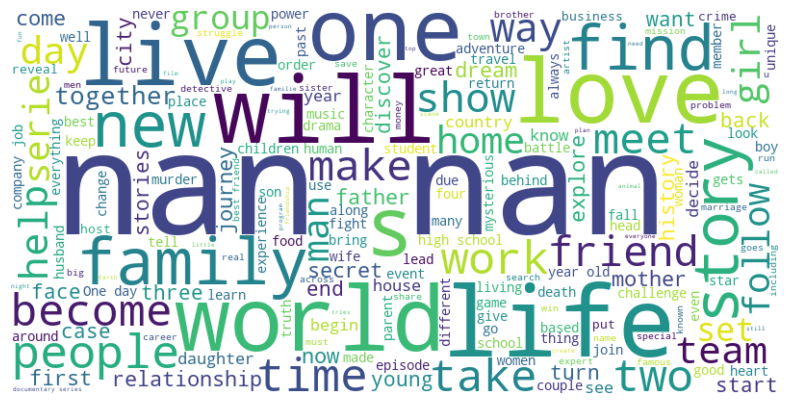

In [6]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt

df_text['overview'] = df_text['overview'].astype(str)

# Step 3: Combine All Text into a Single String
text = " ".join(df_text['overview'])

# Step 4: Create the Word Cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Step 5: Display the Word Cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

### Calculating the sentiment of a TMDB name (put 0 for null overview, disregard homepage

In [7]:
from textblob import TextBlob, Word, Blobber

n = df_text.shape[0]
df_text['polarity'] = np.float64(0)
dfsent = {}

for i in range(0,n):
    tv_show = df_text.loc[i,'name']
    ### Preprocessing
    text = str(df_text.loc[i,'overview'])
    ### skip tv_shows with empty overview
    if text != None:
        text = TextBlob(text)
        ### tokenizing
        dfsent[tv_show] = [text.sentiment[0],text.sentiment[1]]
        first_element = float(text.sentiment[0])
        df_text.at[i,'polarity'] = np.float64(first_element)

In [8]:
df_text.shape

(71370, 5)

In [9]:
df = df.sort_values(by='id')
df = df.reset_index(drop=True)
df_text = df_text.sort_values(by='id')
df_text = df_text.reset_index(drop=True)

In [10]:
df['polarity'] = df_text['polarity']

In [11]:
df.shape

(71370, 74)

In [12]:
#check df info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71370 entries, 0 to 71369
Data columns (total 74 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              71370 non-null  float64
 1   number_of_episodes              71370 non-null  float64
 2   vote_count                      71370 non-null  float64
 3   vote_average                    71370 non-null  float64
 4   adult                           71370 non-null  float64
 5   popularity                      71370 non-null  float64
 6   episode_run_time                71370 non-null  float64
 7   genres_Western                  71370 non-null  float64
 8   genres_Family                   71370 non-null  float64
 9   genres_War & Politics           71370 non-null  float64
 10  genres_Talk                     71370 non-null  float64
 11  genres_Crime                    71370 non-null  float64
 12  genres_Animation                

# present scatterplot ratio between polarity and popularity

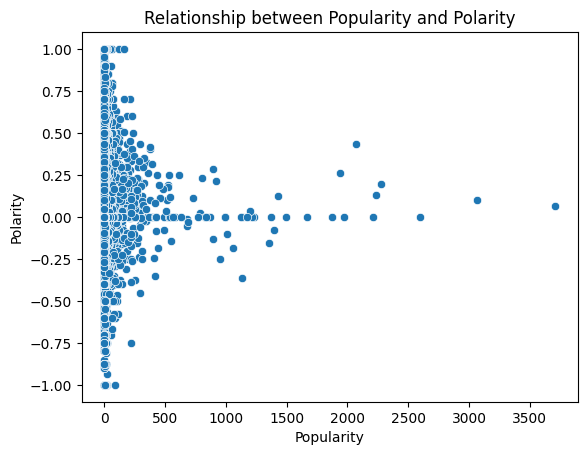

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a scatter plot
sns.scatterplot(x='popularity', y='polarity', data=df)

# Add labels and title
plt.xlabel('Popularity')
plt.ylabel('Polarity')
plt.title('Relationship between Popularity and Polarity')

# Show the plot
plt.show()


# we couldn't find a relationship between popularity and polarity and have decided to drop it from the dataframe

In [14]:
df = df.drop('polarity', axis = 1)

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71370 entries, 0 to 71369
Data columns (total 73 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              71370 non-null  float64
 1   number_of_episodes              71370 non-null  float64
 2   vote_count                      71370 non-null  float64
 3   vote_average                    71370 non-null  float64
 4   adult                           71370 non-null  float64
 5   popularity                      71370 non-null  float64
 6   episode_run_time                71370 non-null  float64
 7   genres_Western                  71370 non-null  float64
 8   genres_Family                   71370 non-null  float64
 9   genres_War & Politics           71370 non-null  float64
 10  genres_Talk                     71370 non-null  float64
 11  genres_Crime                    71370 non-null  float64
 12  genres_Animation                

# Feature Selection Using Multivariable Analysis

In [37]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
import numpy as np

In [38]:
#create a subset of the dataframe with 1000 rows
random_1000_rows = df.sample(n=1000, random_state=42)

y = random_1000_rows['popularity']
X = random_1000_rows.drop(columns=['popularity'])

## Summarization and Selection of Variables

In [39]:
# Fit models and determine if a feature is selected (1) or not (0)
lasso = Lasso(alpha=0.01).fit(X, y)
lasso_selected = (np.abs(lasso.coef_) > 0).astype(int)

# Fit the Linear Regression model
lr = LinearRegression().fit(X, y)
lr_selected = (np.abs(lr.coef_) > 0).astype(int)

gbr = GradientBoostingRegressor().fit(X, y)
gbr_selected = (gbr.feature_importances_ > 0).astype(int)

rfr = RandomForestRegressor().fit(X, y)
rfr_selected = (rfr.feature_importances_ > 0).astype(int)

# Create a DataFrame to store results
selection_df = pd.DataFrame({
    'Feature': X.columns,
    'Lasso': lasso_selected,
    'Linear': lr_selected,
    'GradientBoost': gbr_selected,
    'RandomForest': rfr_selected
})

# Sum the number of selections for each feature
selection_df['Sum'] = selection_df[['Lasso', 'Linear', 'GradientBoost', 'RandomForest']].sum(axis=1)

# Output the results
print(selection_df)


                           Feature  Lasso  Linear  GradientBoost  \
0                               id      1       1              1   
1               number_of_episodes      1       1              1   
2                       vote_count      1       1              1   
3                     vote_average      1       1              1   
4                            adult      1       1              1   
..                             ...    ...     ...            ...   
67         origin_continent_Europe      0       1              1   
68  origin_continent_North America      1       1              1   
69        origin_continent_Oceania      1       1              0   
70  origin_continent_South America      1       1              1   
71          origin_continent_Other      1       1              0   

    RandomForest  Sum  
0              1    4  
1              1    4  
2              1    4  
3              1    4  
4              1    4  
..           ...  ...  
67             

# checking if there is any row with lower than 3 SUM

In [40]:
# Filter the DataFrame where 'sum' is less than 3 and then print the corresponding 'features' column values
print(selection_df[selection_df['Sum'] < 3]['Feature'])

6             genres_Western
13            genres_Romance
18            genres_Musical
21            genres_History
22               genres_News
37                type_Video
40      status_In Production
41              status_Pilot
42            status_Planned
45        networks_Channel 4
47            networks_Other
49    networks_Tencent Video
53            networks_iQiyi
61      original_language_ko
62      original_language_nl
63      original_language_pt
Name: Feature, dtype: object


## Creating DataFrame with most valuable variables - recommended by 3 or more models

In [41]:
#Selecting variables with a sum of selections >= 3
final_var = selection_df[selection_df['Sum'] >= 3]['Feature'].tolist()
df_model = df[final_var].copy()
df_model['popularity'] = df['popularity'].copy()

# Output the result to verify
df_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71370 entries, 0 to 71369
Data columns (total 57 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              71370 non-null  float64
 1   number_of_episodes              71370 non-null  float64
 2   vote_count                      71370 non-null  float64
 3   vote_average                    71370 non-null  float64
 4   adult                           71370 non-null  float64
 5   episode_run_time                71370 non-null  float64
 6   genres_Family                   71370 non-null  float64
 7   genres_War & Politics           71370 non-null  float64
 8   genres_Talk                     71370 non-null  float64
 9   genres_Crime                    71370 non-null  float64
 10  genres_Animation                71370 non-null  float64
 11  genres_Empty                    71370 non-null  float64
 12  genres_Documentary              

# Write new DF (df_model) to pickle 

In [42]:
import pickle

#Write a pickle file
with open('tmdb_EDA_feature_eng_file.pkl', 'wb') as f:
    pickle.dump(df_model, f)

print("TMDB EDA feature_engineered pickle file.")

TMDB EDA feature_engineered pickle file.
